In [9]:
!pip install qiskit-ibm-runtime

  Using cached qiskit_ibm_runtime-0.23.0-py3-none-any.whl.metadata (19 kB)
  Using cached requests_ntlm-1.2.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ibm_platform_services-0.53.7-py3-none-any.whl
  Using cached pydantic-2.7.2-py3-none-any.whl.metadata (108 kB)
  Using cached ibm_cloud_sdk_core-3.20.0-py3-none-any.whl
  Using cached cryptography-42.0.7-cp39-abi3-manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached pyspnego-0.10.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.18.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.5 kB)
  Using cached PyJWT-2.8.0-py3-none-any.whl.metadata (4.2 kB)
Using cached qiskit_ibm_runtime-0.23.0-py3-none-any.whl (3.0 MB)
Using cached requests_ntlm-1.2.0-py3-none-any.whl (6.0 kB)
Using cached pydantic-2.7.2-py3-none-any.whl (409 kB)
Using cached pydantic_core-2.18.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="3938ec2167453e68ce3646104524ba97ba6ac764a519f4d27ae60605457a2573c9c1ae623c61938e759da0b428b13897be8a891a6740628557d539870d873c48")
 
# Load saved credentials
# service = QiskitRuntimeService()

service = QiskitRuntimeService(channel="ibm_quantum", token="3938ec2167453e68ce3646104524ba97ba6ac764a519f4d27ae60605457a2573c9c1ae623c61938e759da0b428b13897be8a891a6740628557d539870d873c48")
 

In [3]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

In [4]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

## Step 1: Map classical inputs to a quantum problem

In [5]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
# )

hamiltonian = SparsePauliOp.from_list(
    [("IIII", -0.0996), 
     ("IIIZ", 0.1711), 
     ("IIZI", 0.1711), 
     ("IZII", -0.2225), 
     ("ZIII", -0.2225), 
     ("IIZZ", 0.1686), 
     ("IZIZ", 0.1205), 
     ("ZIIZ", 0.1658), 
     ("IZZI", 0.1658), 
     ("ZIZI", 0.1205), 
     ("ZZII", 0.1743), 
     ("XYYX", 0.0453), 
     ("YXXY", 0.0453), 
     ("YYXX", -0.0453), 
     ("XXYY", -0.0453)]
)

In [18]:
hamiltonian

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'XYYX', 'YXXY', 'YYXX', 'XXYY'],
              coeffs=[-0.0996+0.j,  0.1711+0.j,  0.1711+0.j, -0.2225+0.j, -0.2225+0.j,
  0.1686+0.j,  0.1205+0.j,  0.1658+0.j,  0.1658+0.j,  0.1205+0.j,
  0.1743+0.j,  0.0453+0.j,  0.0453+0.j, -0.0453+0.j, -0.0453+0.j])

In [7]:
# ansatz = EfficientSU2(hamiltonian.num_qubits)
# ansatz.decompose().draw("mpl", style="iqp")

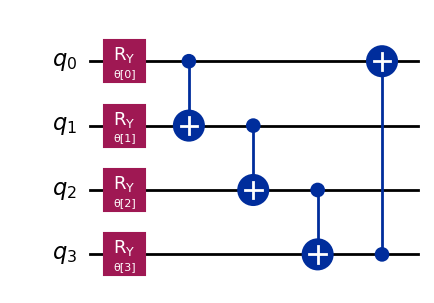

In [8]:
from qiskit.circuit.library import TwoLocal

entangler_map = [[0, 1], [1, 2], [2,3], [3,0]]  # entangle the first and last two-way
ansatz = TwoLocal(hamiltonian.num_qubits, 'ry', 'cx', entangler_map, reps=1, skip_final_rotation_layer=True)

ansatz.decompose().draw("mpl", style="iqp")

In [9]:
num_params = ansatz.num_parameters
num_params

4

## Step 2: Optimize problem for quantum execution.

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

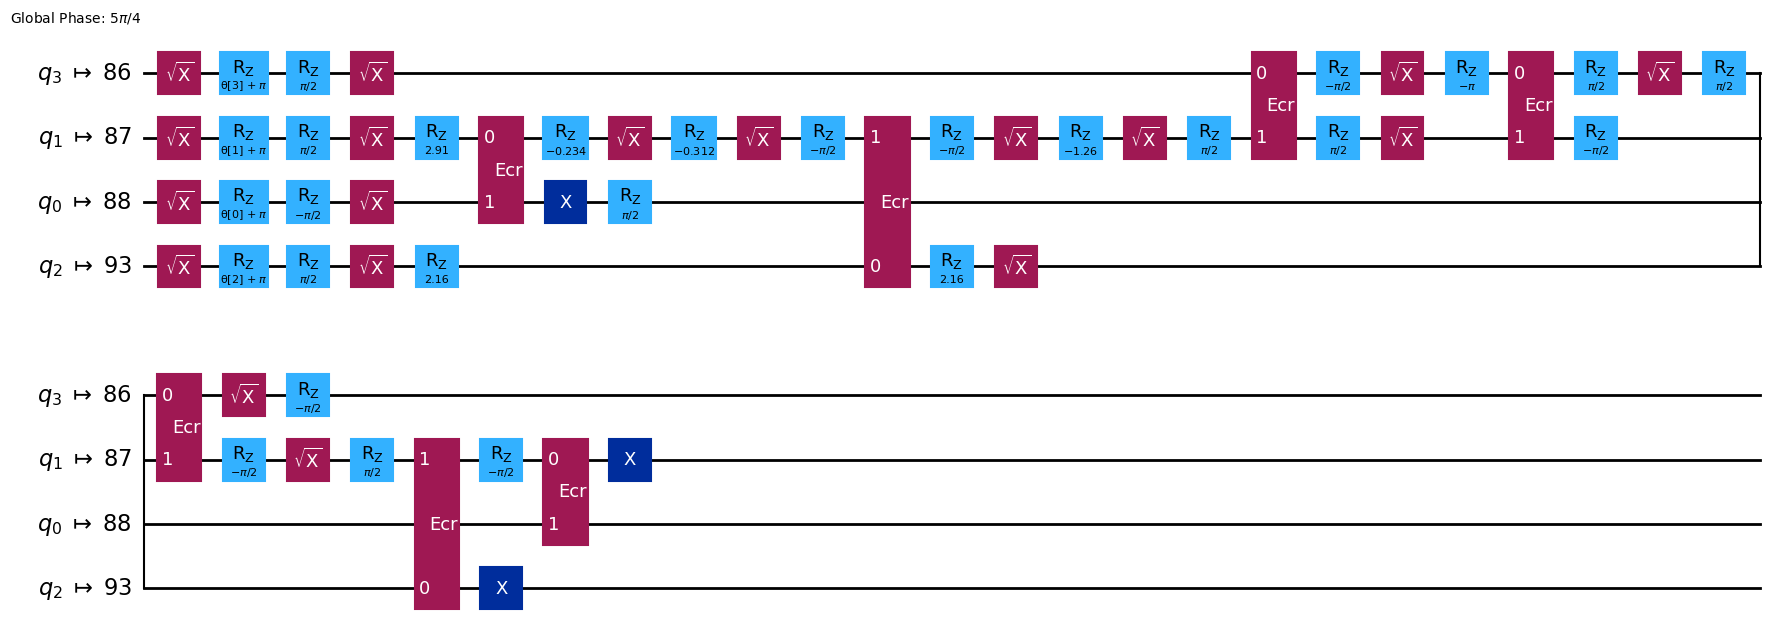

In [11]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [12]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit Primitives.

### COBYLA Optimizer

In [13]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [14]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([4.89874399, 3.92083493, 4.43025277, 5.88012205])

In [17]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 200

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 37 [Current cost: -0.07356534725454364]
Iters. done: 38 [Current cost: -0.08047969932465793]
Iters. done: 39 [Current cost: 0.23770939815518904]
Iters. done: 40 [Current cost: 0.3358681036181487]
Iters. done: 41 [Current cost: -0.1424013866189963]
Iters. done: 42 [Current cost: -0.4847659152352847]
Iters. done: 43 [Current cost: -0.3399984190229691]
Iters. done: 44 [Current cost: -0.46269767461283856]
Iters. done: 45 [Current cost: -0.48460965563623726]
Iters. done: 46 [Current cost: -0.4562503148758088]
Iters. done: 47 [Current cost: -0.3719946356248453]
Iters. done: 48 [Current cost: -0.4684387819600136]
Iters. done: 49 [Current cost: -0.19463077406247456]
Iters. done: 50 [Current cost: -0.4952262195392989]
Iters. done: 51 [Current cost: -0.3527875715904274]
Iters. done: 52 [Current cost: -0.5126912982025136]
Iters. done: 53 [Current cost: -0.31891986825294116]
Iters. done: 54 [Current cost: -0.4097730768638519]
Iters. done: 55 [Current cost: -0.3775498309711591]
Iters. 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

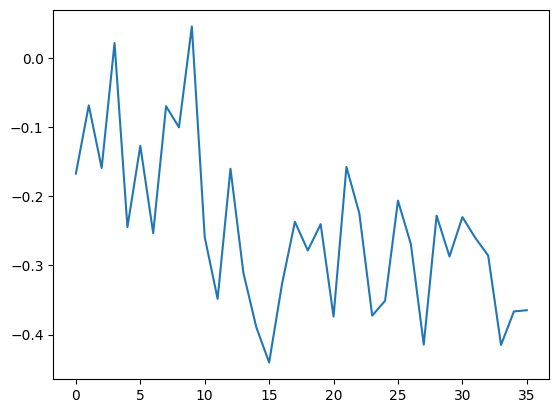

In [16]:
cost_history_dict
plt.plot(cost_history_dict['cost_history'])

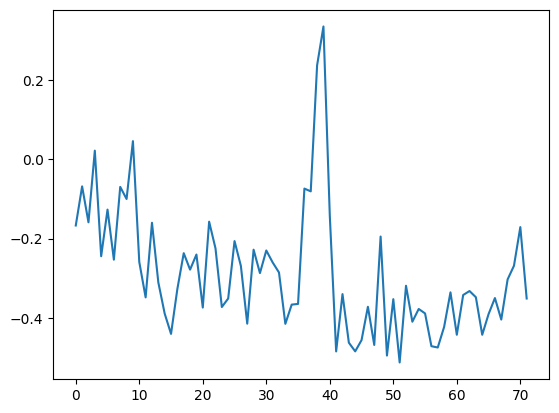

In [19]:
cost_history_dict
plt.plot(cost_history_dict['cost_history'])

## Step 4: Post-process, return result in classical format.

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [23]:
cost_history_dict

{'prev_vector': array([3.05888996, 4.43727613, 5.39903657, 5.66676143, 3.91592233,
        4.00972591, 4.42010001, 2.20419641, 1.54907842, 4.74382172,
        1.6739801 , 4.65247405, 5.86036756, 4.70397595, 0.87260049,
        1.27107314]),
 'iters': 20,
 'cost_history': [0.14922586116758643,
  -0.11612803571621408,
  0.07002776280206445,
  -0.13386988850633055,
  -0.3302387656462088,
  -0.10234731983003965,
  -0.13772207900026967,
  -0.45905039527309566,
  -0.445916509386791,
  -0.36337138067990404,
  -0.42997434693744946,
  -0.28915363465327376,
  -0.35322293062687277,
  -0.5704129149833769,
  -0.47988316089181043,
  -0.46759465876835415,
  -0.24320415638696258,
  -0.588662767522721,
  -0.44708847005466235,
  -0.5228542313152235]}

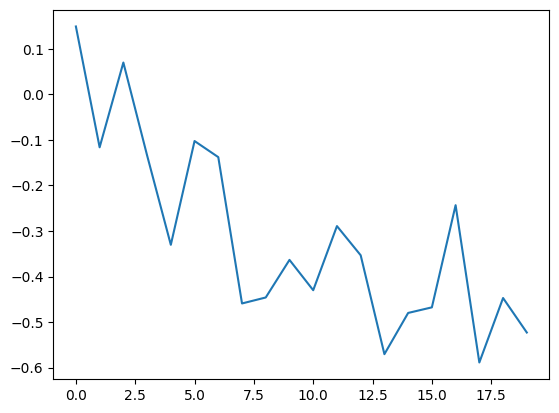

In [25]:
plt.plot(cost_history_dict['cost_history'])